In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import seaborn as sns
sns.set()

In [29]:
#import the libraries
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand

In [30]:
# Defiine functions that performs task 1 mentioned above

#This function will get the coordinates of face given in the annotations file
# the coordinates of lower left corner and upper right corner
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]
#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0 # no mask
#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [31]:
imgs = list(sorted(os.listdir("images")))
len(imgs)

853

In [32]:
labels = list(sorted(os.listdir("annotations")))

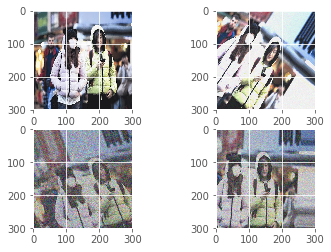

In [33]:
import random
import numpy as np

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Prepare data-augmenting data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.2,1.5],
        preprocessing_function=add_noise,
    )

# Load a single image as our example
from keras.preprocessing import image
img_path = 'C:\\Users\\asus\\Documents\\GitHub\\BT4221\\images\\maksssksksss0.png'
img = image.load_img(img_path, target_size=(299,299))

# Generate distorted images
images = [img]
img_arr = image.img_to_array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)
for batch in datagen.flow(img_arr, batch_size=1):
    images.append( image.array_to_img(batch[0]) )
    if len(images) >= 4:
        break

# Display
import matplotlib.pyplot as plt
f, xyarr = plt.subplots(2,2)
xyarr[0,0].imshow(images[0])
xyarr[0,1].imshow(images[1])
xyarr[1,0].imshow(images[2])
xyarr[1,1].imshow(images[3])
plt.show()

In [34]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("images", file_image)
    label_path = os.path.join("annotations", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)
    
    # print OG photos 
#     img_array = cv2.imread(img_path)
#     print(img_array.shape)
#     b,g,r = cv2.split(img_array)           # get b, g, r
#     rgb_img1 = cv2.merge([r,g,b]) 
#     fig = plt.figure(figsize=(10,5))
#     plt.imshow(rgb_img1)  
#     plt.show()  

In [35]:
#In this step we carry forward the second step mentioned above.
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
for i in range(853):
    img_path = r"images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)
    b,g,r = cv2.split(img)           # get b, g, r
    rgb_img1 = cv2.merge([r,g,b])
    img = rgb_img1
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))        
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)



In [36]:
len(face_labels)
unique, counts = np.unique(face_labels, return_counts=True)
count = dict(zip(unique, counts))
count

{0: 717, 1: 3232, 2: 123}

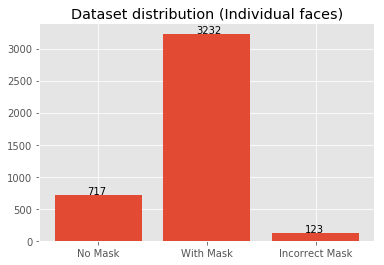

In [37]:
plt.bar(count.keys(), count.values(), tick_label=["No Mask","With Mask","Incorrect Mask"])
plt.title("Dataset distribution (Individual faces)")

for k, v in count.items():
    plt.text(int(k)-0.1, int(v)+10, str(v))

In [38]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [39]:
#Perform data augmentation.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [40]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [41]:
# for batch in datagen.flow(img_arr, batch_size=1, save_to_dir = "test"):
#     images.append( image.array_to_img(batch[0]) )
#     if len(images) >= 4:
#         break

# # Display
# import matplotlib.pyplot as plt
# f, xyarr = plt.subplots(2,2)
# xyarr[0,0].imshow(images[0])
# xyarr[0,1].imshow(images[1])
# xyarr[1,0].imshow(images[2])
# xyarr[1,1].imshow(images[3])
# plt.show()

In [42]:
print("Number of training data: " + str(len(trainX)), "\nNumber of test data: " + str(len(testX)))

Number of training data: 3257 
Number of test data: 815


In [52]:
# for the trainset 
unique, counts = np.unique(trainY, return_counts=True)
count = dict(zip(unique, counts))
#count

train_label = np.argmax(trainY,axis=1)
unique, counts = np.unique(train_label, return_counts=True)
count = dict(zip(unique, counts))
count

{0: 574, 1: 2585, 2: 98}

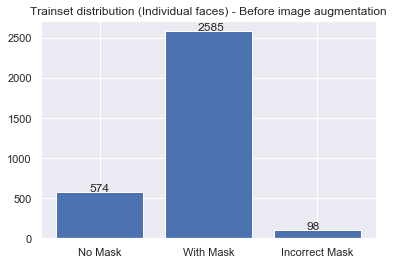

In [54]:
plt.bar(count.keys(), count.values(), tick_label=["No Mask","With Mask","Incorrect Mask"])
plt.title("Trainset distribution (Individual faces) - Before image augmentation")

for k, v in count.items():
    plt.text(int(k)-0.1, int(v)+10, str(v))

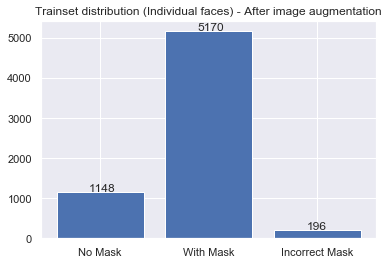

In [57]:
train_label = np.argmax(trainY,axis=1)
unique, counts = np.unique(train_label, return_counts=True)
count = dict(zip(unique, counts * 2))
count

plt.bar(count.keys(), count.values(), tick_label=["No Mask","With Mask","Incorrect Mask"])
plt.title("Trainset distribution (Individual faces) - After image augmentation")

for k, v in count.items():
    plt.text(int(k)-0.1, int(v)+10, str(v))

In [45]:
# for the testset 
unique, counts = np.unique(testY, return_counts=True)
count = dict(zip(unique, counts))
#count

test_label = np.argmax(testY,axis=1)
unique, counts = np.unique(test_label, return_counts=True)
count = dict(zip(unique, counts))
count

{0: 143, 1: 647, 2: 25}

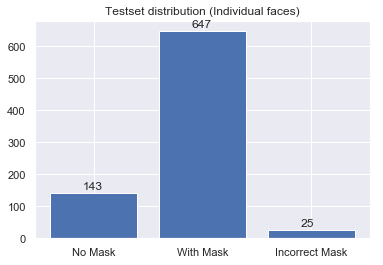

In [51]:
plt.bar(count.keys(), count.values(), tick_label=["No Mask","With Mask","Incorrect Mask"])
plt.title("Testset distribution (Individual faces)")

for k, v in count.items():
    plt.text(int(k)-0.1, int(v)+10, str(v))

In [47]:
#define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 5
BS = 1

In [49]:
from matplotlib import pyplot

augmented = datagen.flow(trainX, trainY, batch_size=BS, save_to_dir = "test")

for i in range(len(trainX)): 
    batch = augmented.next()


In [22]:
# training the model 

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

C:\Users\asus\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [23]:
#Free some space.I did this tep as the notebook was running out of space while training
del targets,face_images,face_labels

In [24]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
start = time.time()
H = model.fit(
  augmented,
  steps_per_epoch=len(trainX) // BS,
  validation_data=(testX, testY),
  validation_steps=len(testX) // BS,
  epochs=EPOCHS)
print("Total time: ", time.time() - start, "seconds")

[INFO] training head...
Train for 3257 steps, validate on 815 samples
Epoch 1/5
3257/3257 [==============================] - 725s 223ms/step - loss: 0.6597 - accuracy: 0.7875 - val_loss: 0.6734 - val_accuracy: 0.7939
Epoch 2/5
3257/3257 [==============================] - 738s 227ms/step - loss: 0.6514 - accuracy: 0.7903 - val_loss: 0.6582 - val_accuracy: 0.7939
Epoch 3/5
3257/3257 [==============================] - 782s 240ms/step - loss: 0.6365 - accuracy: 0.7937 - val_loss: 0.6572 - val_accuracy: 0.7939
Epoch 4/5
3257/3257 [==============================] - 806s 247ms/step - loss: 0.6317 - accuracy: 0.7937 - val_loss: 0.6534 - val_accuracy: 0.7939
Epoch 5/5
3257/3257 [==============================] - 828s 254ms/step - loss: 0.6414 - accuracy: 0.7937 - val_loss: 0.6469 - val_accuracy: 0.7939
Total time:  4032.5823044776917 seconds


[INFO] evaluating network...


C:\Users\asus\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.79      1.00      0.89       647
           2       0.00      0.00      0.00        25

    accuracy                           0.79       815
   macro avg       0.26      0.33      0.30       815
weighted avg       0.63      0.79      0.70       815



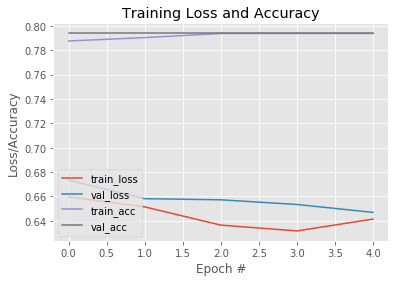

In [25]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# plot the training loss and accuracy
N = EPOCHSx
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

2